In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

device(type='cpu')

In [2]:
import math
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

In [3]:
torch.manual_seed(0)

n_samples = 1500
n_features = 3
n_components = 3

In [4]:
true_pis = torch.tensor([0.3, 0.5, 0.2])
true_mus = torch.tensor([
    [-2.0, -2.0, -2.0],
    [0.0, 2.0, 0.0],
    [3.0, 3.0, 3.0]
])

true_vars = torch.tensor([
    [0.8, 1.0, 0.5],
    [1.2, 0.7, 1.1],
    [0.6, 0.6, 0.6]
])


X_3d = torch.zeros(n_samples, n_features)

for i in range(n_samples):
    k = torch.multinomial(true_pis, 1)[0]
    mu = true_mus[k]
    std = torch.sqrt(true_vars[k])
    noise = torch.randn(n_features)
    X_3d[i] = mu + std * noise

print("Dataset shape:", X_3d.shape)

Dataset shape: torch.Size([1500, 3])


In [5]:
def gaussian_pdf(xb, mus, variances):
    B, D = xb.shape
    K, _ = mus.shape
    pdfs = torch.zeros(B, K)

    for i in range(B):
        x = xb[i] 
        for k in range(K):
            mu = mus[k]
            var = variances[k]
            # Normalization constant: (2π)^(-D/2) * |Σ|^(-1/2)
            determinant = torch.prod(var)
            norm_const = (2 * torch.pi)**(-D / 2) * (determinant**-0.5)
            # Exponent: exp(-0.5 * (x-μ)^T Σ^(-1) (x-μ))
            diff = x - mu
            inv_cov = torch.diag(1.0 / var)
            exponent = -0.5 * (diff.T @ inv_cov @ diff)
            pdfs[i, k] = norm_const * torch.exp(exponent)
    return pdfs

In [6]:
def calculate_responsibilities(xb, pis, mus, variances):
    weighted_pdfs = pis * gaussian_pdf(xb, mus, variances)
    total_likelihood = torch.sum(weighted_pdfs, dim=1, keepdim=True)
    responsibilities = weighted_pdfs / total_likelihood
    return responsibilities, total_likelihood

In [7]:
def calculate_mean_gradient(xb, responsibilities, mus, variances):
    B, D = xb.shape
    K, _ = mus.shape
    grad_mus = torch.zeros_like(mus)
    # Gradient formula: Σ_i [γ_ik * Σ_k^(-1) * (x_i - μ_k)]
    for k in range(K):
        grad_mu_k = torch.zeros(D)
        for i in range(B):
            diff = xb[i] - mus[k]
            inv_cov_k = torch.diag(1.0 / variances[k])
            grad_mu_k += responsibilities[i, k] * (inv_cov_k @ diff)
        grad_mus[k] = grad_mu_k
    return grad_mus

In [8]:
def calculate_log_variance_gradient(xb, responsibilities, mus, variances):
    diff_sq = (xb.unsqueeze(1) - mus.unsqueeze(0))**2
    term_in_brackets = (diff_sq / variances.unsqueeze(0)) - 1
    grad_log_vars = 0.5 * torch.sum(responsibilities.unsqueeze(2) * term_in_brackets, dim=0)
    return grad_log_vars

In [9]:
def calculate_pi_logit_gradient(responsibilities, pis):
    grad_pi_logits = torch.sum(responsibilities - pis.unsqueeze(0), dim=0)
    return grad_pi_logits

In [10]:
K, D = n_components, n_features
perm = torch.randperm(n_samples)
mus = X_3d[perm[:K]].clone()
log_vars = torch.randn(K, D)
pi_logits = torch.randn(K)
learning_rate = 0.01
epochs = 300
batch_size = 128

In [11]:
for epoch in range(epochs):
    indices = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i : i + batch_size]
        xb = X_3d[batch_indices]
        # Forward Pass
        pis = torch.softmax(pi_logits, dim=0)
        variances = torch.exp(log_vars)
        # Calculate Responsibilities
        responsibilities, likelihoods = calculate_responsibilities(xb, pis, mus, variances)
        # Calculate Gradients
        grad_mus = calculate_mean_gradient(xb, responsibilities, mus, variances)
        grad_log_vars = calculate_log_variance_gradient(xb, responsibilities, mus, variances)
        grad_pi_logits = calculate_pi_logit_gradient(responsibilities, pis)
        # Update
        mus += learning_rate * grad_mus
        log_vars += learning_rate * grad_log_vars
        pi_logits += learning_rate * grad_pi_logits
    if (epoch + 1) % 50 == 0:
        loss = -torch.log(likelihoods).mean() # type: ignore
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")



/tmp/ipykernel_23113/3483860048.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  exponent = -0.5 * (diff.T @ inv_cov @ diff)


Epoch 50/300, Loss: 4.9686
Epoch 100/300, Loss: 5.0671
Epoch 150/300, Loss: 5.1069
Epoch 200/300, Loss: 5.1723
Epoch 250/300, Loss: 5.4018
Epoch 300/300, Loss: 4.8613


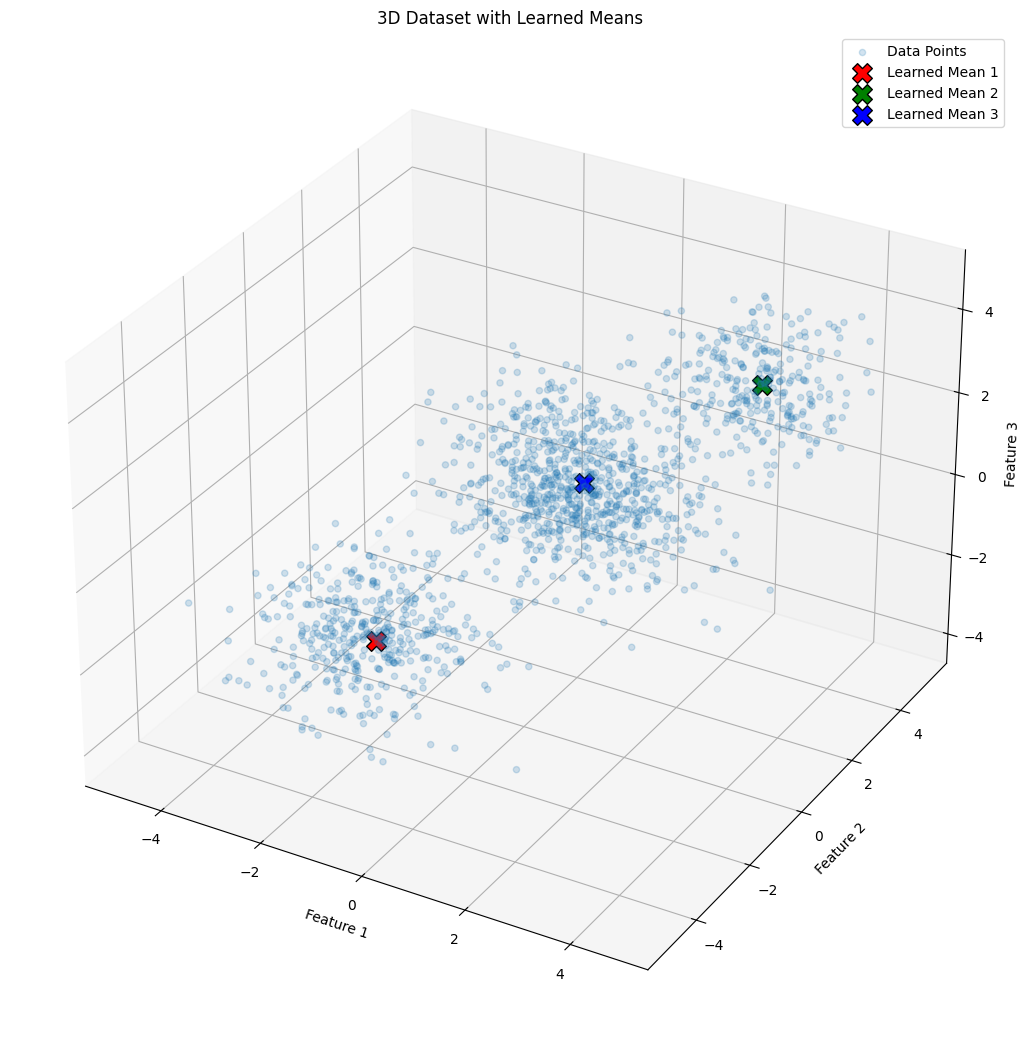

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], alpha=0.2, label='Data Points')

colors = ['r', 'g', 'b']
for k in range(K):
    ax.scatter(
        mus[k, 0], mus[k, 1], mus[k, 2], 
        c=colors[k], marker='X', s=200, edgecolor='black', label=f'Learned Mean {k+1}'
    )

ax.set_title('3D Dataset with Learned Means')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.show()